# ORF recognition by Convolutional/Recurrent

Test CNN+LSTM 32 on simulated RNA of length 64. 

Use restructured codebase from notebook 105.

In [1]:
import time 
t = time.time()
time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t))

'2021-06-21 17:00:55 UTC'

In [2]:
PC_SEQUENCES=32000   # how many protein-coding sequences
NC_SEQUENCES=32000   # how many non-coding sequences
PC_TESTS=1000
NC_TESTS=1000
RNA_LEN=64            # how long is each sequence
CDS_LEN=32            # min CDS len to be coding
ALPHABET=4          # how many different letters are possible
INPUT_SHAPE_2D = (RNA_LEN,ALPHABET,1) # Conv2D needs 3D inputs
INPUT_SHAPE = (RNA_LEN,ALPHABET) # Conv1D needs 2D inputs
FILTERS = 32   # how many different patterns the model looks for
CELLS = 32
NEURONS = 32
DROP_RATE = 0.4
WIDTH = 3   # how wide each pattern is, in bases
STRIDE_2D = (1,1)  # For Conv2D how far in each direction
STRIDE = 1 # For Conv1D, how far between pattern matches, in bases
EPOCHS=100  # how many times to train on all the data
SPLITS=3  # SPLITS=3 means train on 2/3 and validate on 1/3 
FOLDS=3  # train the model this many times (range 1 to SPLITS)

In [3]:
import sys
IN_COLAB = False
try:
    from google.colab import drive
    IN_COLAB = True
except:
    pass
if IN_COLAB:
    print("On Google CoLab, mount cloud-local file, get our code from GitHub.")
    PATH='/content/drive/'
    #drive.mount(PATH,force_remount=True)  # hardly ever need this
    #drive.mount(PATH)    # Google will require login credentials
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_describe.py')
    with open('RNA_describe.py', 'w') as f:
        f.write(r.text)  
    from RNA_describe import ORF_counter
    from RNA_describe import Random_Base_Oracle
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_prep.py')
    with open('RNA_prep.py', 'w') as f:
        f.write(r.text)  
    from RNA_prep import prepare_inputs_len_x_alphabet
else:
        print("CoLab not working. On my PC, use relative paths.")
        DATAPATH='data/'  # must end in "/"
        sys.path.append("..") # append parent dir in order to use sibling dirs
        from SimTools.RNA_describe import ORF_counter,Random_Base_Oracle
        from SimTools.RNA_prep import prepare_inputs_len_x_alphabet

MODELPATH="BestModel"  # saved on cloud instance and lost after logout
#MODELPATH=DATAPATH+MODELPATH  # saved on Google Drive but requires login


On Google CoLab, mount cloud-local file, get our code from GitHub.


In [4]:
from os import listdir
import csv
from zipfile import ZipFile

import numpy as np
import pandas as pd
from scipy import stats  # mode

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from keras.models import Sequential
from keras.layers import Dense,Embedding,Dropout
from keras.layers import Conv1D,Conv2D
from keras.layers import GRU,LSTM
from keras.layers import Flatten,TimeDistributed
from keras.layers import MaxPooling1D,MaxPooling2D
from keras.losses import BinaryCrossentropy
# tf.keras.losses.BinaryCrossentropy

import matplotlib.pyplot as plt
from matplotlib import colors
mycmap = colors.ListedColormap(['red','blue'])  # list color for label 0 then 1
np.set_printoptions(precision=2)


In [5]:
rbo=Random_Base_Oracle(RNA_LEN,True)
pc_all,nc_all = rbo.get_partitioned_sequences(CDS_LEN,10) # just testing
pc_all,nc_all = rbo.get_partitioned_sequences(CDS_LEN,PC_SEQUENCES+PC_TESTS)
print("Use",len(pc_all),"PC seqs")
print("Use",len(nc_all),"NC seqs")

It took 30 trials to reach 10 per class.
It took 104074 trials to reach 33000 per class.
Use 33000 PC seqs
Use 33000 NC seqs


In [6]:
# Describe the sequences
def describe_sequences(list_of_seq):
    oc = ORF_counter()
    num_seq = len(list_of_seq)
    rna_lens = np.zeros(num_seq)
    orf_lens = np.zeros(num_seq)
    for i in range(0,num_seq):
        rna_len = len(list_of_seq[i])
        rna_lens[i] = rna_len
        oc.set_sequence(list_of_seq[i])
        orf_len = oc.get_max_orf_len()
        orf_lens[i] = orf_len
    print ("Average RNA length:",rna_lens.mean())
    print ("Average ORF length:",orf_lens.mean())
    
print("Simulated sequences prior to adjustment:")
print("PC seqs")
describe_sequences(pc_all)
print("NC seqs")
describe_sequences(nc_all)

Simulated sequences prior to adjustment:
PC seqs
Average RNA length: 64.0
Average ORF length: 38.33445454545455
NC seqs
Average RNA length: 64.0
Average ORF length: 8.254545454545454


In [7]:
pc_train=pc_all[:PC_SEQUENCES]
nc_train=nc_all[:NC_SEQUENCES]
pc_test=pc_all[PC_SEQUENCES:]
nc_test=nc_all[NC_SEQUENCES:]

In [8]:
# Use code from our SimTools library.
X,y = prepare_inputs_len_x_alphabet(pc_train,nc_train,ALPHABET) # shuffles
print("Data ready.")

Data ready.


In [9]:
def make_DNN():
    print("make_DNN")
    print("input shape:",INPUT_SHAPE)
    dnn = Sequential()
    #dnn.add(Embedding(input_dim=INPUT_SHAPE,output_dim=INPUT_SHAPE)) 
    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same",
            input_shape=INPUT_SHAPE))
    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    dnn.add(MaxPooling1D())
    #dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    #dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    #dnn.add(MaxPooling1D())
    #dnn.add(TimeDistributed(Flatten()))
    dnn.add(GRU(CELLS,return_sequences=True))
    dnn.add(GRU(CELLS,return_sequences=False))
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=np.float32))   
    dnn.add(Dropout(DROP_RATE))
    dnn.add(Dense(1,activation="sigmoid",dtype=np.float32))   
    dnn.compile(optimizer='adam',
                loss=BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])   # add to default metrics=loss
    dnn.build(input_shape=INPUT_SHAPE)
    #ln_rate = tf.keras.optimizers.Adam(learning_rate = LN_RATE)
    #bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    #model.compile(loss=bc, optimizer=ln_rate, metrics=["accuracy"])
    return dnn
model = make_DNN()
print(model.summary())

make_DNN
input shape: (64, 4)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 64, 32)            416       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 64, 32)            3104      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 32, 32)            0         
_________________________________________________________________
gru (GRU)                    (None, 32, 32)            6336      
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                6336      
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dropout (Dropout)         

In [10]:
from keras.callbacks import ModelCheckpoint
def do_cross_validation(X,y):
    cv_scores = []
    fold=0
    mycallbacks = [ModelCheckpoint(
        filepath=MODELPATH, save_best_only=True, 
        monitor='val_accuracy', mode='max')]   
    splitter = KFold(n_splits=SPLITS)  # this does not shuffle
    for train_index,valid_index in splitter.split(X):
        if fold < FOLDS:
            fold += 1
            X_train=X[train_index] # inputs for training
            y_train=y[train_index] # labels for training
            X_valid=X[valid_index] # inputs for validation
            y_valid=y[valid_index] # labels for validation
            print("MODEL")
            # Call constructor on each CV. Else, continually improves the same model.
            model = model = make_DNN()
            print("FIT")  # model.fit() implements learning
            start_time=time.time()
            history=model.fit(X_train, y_train, 
                    epochs=EPOCHS, 
                    verbose=1,  # ascii art while learning
                    callbacks=mycallbacks,   # called at end of each epoch
                    validation_data=(X_valid,y_valid))
            end_time=time.time()
            elapsed_time=(end_time-start_time)                        
            print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
            # print(history.history.keys())  # all these keys will be shown in figure
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1) # any losses > 1 will be off the scale
            plt.show()


MODEL
make_DNN
input shape: (64, 4)
FIT
Epoch 1/100
1334/1334 [==============================] - 36s 11ms/step - loss: 0.6894 - accuracy: 0.5478 - val_loss: 0.6319 - val_accuracy: 0.6342


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 2/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.6271 - accuracy: 0.6390 - val_loss: 0.5846 - val_accuracy: 0.6771


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 3/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.5823 - accuracy: 0.6822 - val_loss: 0.5743 - val_accuracy: 0.6844


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 4/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.5618 - accuracy: 0.6973 - val_loss: 0.5519 - val_accuracy: 0.6981


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 5/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.5555 - accuracy: 0.6962 - val_loss: 0.5453 - val_accuracy: 0.7030


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 6/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.5464 - accuracy: 0.7051 - val_loss: 0.5439 - val_accuracy: 0.6990
Epoch 7/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.5352 - accuracy: 0.7119 - val_loss: 0.5500 - val_accuracy: 0.7054


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 8/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.5303 - accuracy: 0.7148 - val_loss: 0.5683 - val_accuracy: 0.6926
Epoch 9/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.5240 - accuracy: 0.7201 - val_loss: 0.5389 - val_accuracy: 0.7093


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 10/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.5230 - accuracy: 0.7210 - val_loss: 0.5317 - val_accuracy: 0.7103


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 11/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.5139 - accuracy: 0.7242 - val_loss: 0.5317 - val_accuracy: 0.7136


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 12/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.5147 - accuracy: 0.7256 - val_loss: 0.5392 - val_accuracy: 0.7094
Epoch 13/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.5072 - accuracy: 0.7314 - val_loss: 0.5262 - val_accuracy: 0.7127
Epoch 14/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.5039 - accuracy: 0.7311 - val_loss: 0.5203 - val_accuracy: 0.7187


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 15/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.4975 - accuracy: 0.7385 - val_loss: 0.5229 - val_accuracy: 0.7250


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 16/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.4936 - accuracy: 0.7397 - val_loss: 0.5070 - val_accuracy: 0.7279


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 17/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.4735 - accuracy: 0.7542 - val_loss: 0.5821 - val_accuracy: 0.6957
Epoch 18/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.4084 - accuracy: 0.8089 - val_loss: 0.3937 - val_accuracy: 0.8326


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 19/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.3125 - accuracy: 0.8663 - val_loss: 0.4194 - val_accuracy: 0.8156
Epoch 20/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.4432 - accuracy: 0.7940 - val_loss: 0.2437 - val_accuracy: 0.8999


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 21/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.2140 - accuracy: 0.9129 - val_loss: 0.1317 - val_accuracy: 0.9458


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 22/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.1380 - accuracy: 0.9443 - val_loss: 0.1069 - val_accuracy: 0.9515


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 23/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.1087 - accuracy: 0.9547 - val_loss: 0.1029 - val_accuracy: 0.9551


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 24/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.0952 - accuracy: 0.9581 - val_loss: 0.0842 - val_accuracy: 0.9607


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 25/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.0978 - accuracy: 0.9555 - val_loss: 0.2836 - val_accuracy: 0.8926
Epoch 26/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.1216 - accuracy: 0.9460 - val_loss: 0.1037 - val_accuracy: 0.9535
Epoch 27/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.1086 - accuracy: 0.9510 - val_loss: 0.0845 - val_accuracy: 0.9597
Epoch 28/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.0878 - accuracy: 0.9601 - val_loss: 0.0904 - val_accuracy: 0.9592
Epoch 29/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.1158 - accuracy: 0.9497 - val_loss: 0.0897 - val_accuracy: 0.9568
Epoch 30/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.1564 - accuracy: 0.9352 - val_loss: 0.0964 - val_accuracy: 0.9537
Epoch 31/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.0984 - accuracy: 0.9541 - val_

INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 33/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.0878 - accuracy: 0.9582 - val_loss: 0.0809 - val_accuracy: 0.9591
Epoch 34/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.0742 - accuracy: 0.9634 - val_loss: 0.0918 - val_accuracy: 0.9572
Epoch 35/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.1076 - accuracy: 0.9508 - val_loss: 0.0859 - val_accuracy: 0.9576
Epoch 36/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.0934 - accuracy: 0.9553 - val_loss: 0.0905 - val_accuracy: 0.9544
Epoch 37/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.0952 - accuracy: 0.9553 - val_loss: 0.0899 - val_accuracy: 0.9580
Epoch 38/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.0806 - accuracy: 0.9604 - val_loss: 0.0788 - val_accuracy: 0.9618


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 39/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.0764 - accuracy: 0.9626 - val_loss: 0.0815 - val_accuracy: 0.9600
Epoch 40/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.0794 - accuracy: 0.9615 - val_loss: 0.0687 - val_accuracy: 0.9663


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 41/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.0687 - accuracy: 0.9677 - val_loss: 0.0710 - val_accuracy: 0.9648
Epoch 42/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.0753 - accuracy: 0.9650 - val_loss: 0.0828 - val_accuracy: 0.9593
Epoch 43/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.0699 - accuracy: 0.9662 - val_loss: 0.0728 - val_accuracy: 0.9647
Epoch 44/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.0638 - accuracy: 0.9687 - val_loss: 0.0884 - val_accuracy: 0.9621
Epoch 45/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.0681 - accuracy: 0.9661 - val_loss: 0.0668 - val_accuracy: 0.9692


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 46/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.0558 - accuracy: 0.9727 - val_loss: 0.2624 - val_accuracy: 0.9323
Epoch 47/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.0816 - accuracy: 0.9680 - val_loss: 0.0631 - val_accuracy: 0.9704


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 48/100
1334/1334 [==============================] - 14s 10ms/step - loss: 0.0576 - accuracy: 0.9723 - val_loss: 0.0733 - val_accuracy: 0.9685
Epoch 49/100
1334/1334 [==============================] - 14s 10ms/step - loss: 0.0652 - accuracy: 0.9721 - val_loss: 0.0724 - val_accuracy: 0.9686
Epoch 50/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.0633 - accuracy: 0.9705 - val_loss: 0.0721 - val_accuracy: 0.9690
Epoch 51/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.0615 - accuracy: 0.9730 - val_loss: 0.0654 - val_accuracy: 0.9699
Epoch 52/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.0539 - accuracy: 0.9744 - val_loss: 0.0636 - val_accuracy: 0.9708


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 53/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.0555 - accuracy: 0.9740 - val_loss: 0.0719 - val_accuracy: 0.9659
Epoch 54/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.0906 - accuracy: 0.9591 - val_loss: 0.0691 - val_accuracy: 0.9685
Epoch 55/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.0657 - accuracy: 0.9709 - val_loss: 0.0678 - val_accuracy: 0.9697
Epoch 56/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.0632 - accuracy: 0.9709 - val_loss: 0.0744 - val_accuracy: 0.9642
Epoch 57/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.0602 - accuracy: 0.9711 - val_loss: 0.0659 - val_accuracy: 0.9688
Epoch 58/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.0778 - accuracy: 0.9648 - val_loss: 0.0608 - val_accuracy: 0.9731


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 59/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.0561 - accuracy: 0.9740 - val_loss: 0.0616 - val_accuracy: 0.9713
Epoch 60/100
1334/1334 [==============================] - 14s 10ms/step - loss: 0.0476 - accuracy: 0.9763 - val_loss: 0.0592 - val_accuracy: 0.9725
Epoch 61/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.0878 - accuracy: 0.9564 - val_loss: 0.1682 - val_accuracy: 0.9293
Epoch 62/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.0981 - accuracy: 0.9570 - val_loss: 0.0594 - val_accuracy: 0.9727
Epoch 63/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.0492 - accuracy: 0.9781 - val_loss: 0.0573 - val_accuracy: 0.9744


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 64/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.0431 - accuracy: 0.9800 - val_loss: 0.0498 - val_accuracy: 0.9765


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 65/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.0521 - accuracy: 0.9776 - val_loss: 0.0680 - val_accuracy: 0.9695
Epoch 66/100
1334/1334 [==============================] - 14s 10ms/step - loss: 0.0582 - accuracy: 0.9754 - val_loss: 0.0638 - val_accuracy: 0.9733
Epoch 67/100
1334/1334 [==============================] - 14s 10ms/step - loss: 0.0615 - accuracy: 0.9729 - val_loss: 0.6419 - val_accuracy: 0.7042
Epoch 68/100
1334/1334 [==============================] - 14s 10ms/step - loss: 0.6025 - accuracy: 0.6557 - val_loss: 0.3768 - val_accuracy: 0.8246
Epoch 69/100
1334/1334 [==============================] - 14s 10ms/step - loss: 0.2282 - accuracy: 0.9010 - val_loss: 0.0822 - val_accuracy: 0.9663
Epoch 70/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.0705 - accuracy: 0.9712 - val_loss: 0.0637 - val_accuracy: 0.9734
Epoch 71/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.0520 - accuracy: 0.9787 - val_

INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 73/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.3106 - accuracy: 0.8371 - val_loss: 0.1819 - val_accuracy: 0.9475
Epoch 74/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.0620 - accuracy: 0.9763 - val_loss: 0.0550 - val_accuracy: 0.9768
Epoch 75/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.0431 - accuracy: 0.9839 - val_loss: 0.0478 - val_accuracy: 0.9804


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 76/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.0329 - accuracy: 0.9870 - val_loss: 0.0393 - val_accuracy: 0.9839


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 77/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.0291 - accuracy: 0.9881 - val_loss: 0.0485 - val_accuracy: 0.9806
Epoch 78/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.0386 - accuracy: 0.9855 - val_loss: 0.0429 - val_accuracy: 0.9833
Epoch 79/100
1334/1334 [==============================] - 14s 10ms/step - loss: 0.0334 - accuracy: 0.9874 - val_loss: 0.0417 - val_accuracy: 0.9826
Epoch 80/100
1334/1334 [==============================] - 14s 10ms/step - loss: 0.0434 - accuracy: 0.9834 - val_loss: 0.0380 - val_accuracy: 0.9840


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 81/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.0284 - accuracy: 0.9900 - val_loss: 0.0338 - val_accuracy: 0.9873


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 82/100
1334/1334 [==============================] - 14s 10ms/step - loss: 0.0303 - accuracy: 0.9886 - val_loss: 0.0738 - val_accuracy: 0.9703
Epoch 83/100
1334/1334 [==============================] - 14s 10ms/step - loss: 0.0491 - accuracy: 0.9807 - val_loss: 0.0668 - val_accuracy: 0.9737
Epoch 84/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.0883 - accuracy: 0.9671 - val_loss: 0.0406 - val_accuracy: 0.9846
Epoch 85/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.0314 - accuracy: 0.9887 - val_loss: 0.0381 - val_accuracy: 0.9851
Epoch 86/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.0224 - accuracy: 0.9915 - val_loss: 0.0359 - val_accuracy: 0.9860
Epoch 87/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.0351 - accuracy: 0.9846 - val_loss: 0.6897 - val_accuracy: 0.5486
Epoch 88/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.6567 - accuracy: 0.6089 - val_

INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 96/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.0244 - accuracy: 0.9905 - val_loss: 0.0400 - val_accuracy: 0.9847
Epoch 97/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.0255 - accuracy: 0.9897 - val_loss: 0.0739 - val_accuracy: 0.9705
Epoch 98/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.2093 - accuracy: 0.8922 - val_loss: 0.1161 - val_accuracy: 0.9562
Epoch 99/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.0730 - accuracy: 0.9716 - val_loss: 0.0469 - val_accuracy: 0.9815
Epoch 100/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.0317 - accuracy: 0.9878 - val_loss: 0.0431 - val_accuracy: 0.9840
Fold 1, 100 epochs, 1660 sec


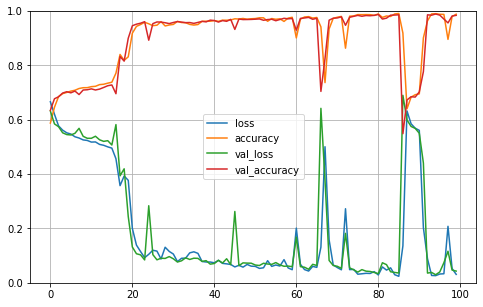

MODEL
make_DNN
input shape: (64, 4)
FIT
Epoch 1/100
1334/1334 [==============================] - 19s 11ms/step - loss: 0.6910 - accuracy: 0.5413 - val_loss: 0.6287 - val_accuracy: 0.6341
Epoch 2/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.6293 - accuracy: 0.6380 - val_loss: 0.6188 - val_accuracy: 0.6476
Epoch 3/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.6176 - accuracy: 0.6495 - val_loss: 0.5904 - val_accuracy: 0.6735
Epoch 4/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.5870 - accuracy: 0.6771 - val_loss: 0.5576 - val_accuracy: 0.6931
Epoch 5/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.5569 - accuracy: 0.7008 - val_loss: 0.5447 - val_accuracy: 0.6939
Epoch 6/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.5469 - accuracy: 0.7058 - val_loss: 0.5468 - val_accuracy: 0.7008
Epoch 7/100
1334/1334 [==============================] - 13s 10ms/step - loss:

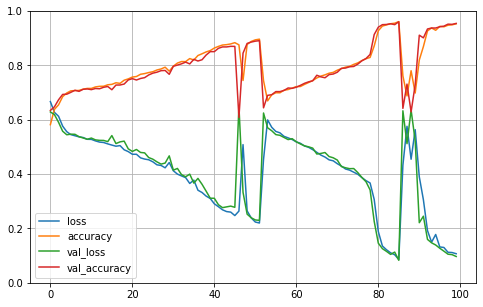

MODEL
make_DNN
input shape: (64, 4)
FIT
Epoch 1/100
1334/1334 [==============================] - 18s 11ms/step - loss: 0.6946 - accuracy: 0.5423 - val_loss: 0.6304 - val_accuracy: 0.6342
Epoch 2/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.6291 - accuracy: 0.6381 - val_loss: 0.6167 - val_accuracy: 0.6509
Epoch 3/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.6052 - accuracy: 0.6636 - val_loss: 0.5757 - val_accuracy: 0.6894
Epoch 4/100
1334/1334 [==============================] - 14s 10ms/step - loss: 0.5663 - accuracy: 0.6928 - val_loss: 0.5515 - val_accuracy: 0.6991
Epoch 5/100
1334/1334 [==============================] - 14s 10ms/step - loss: 0.5514 - accuracy: 0.7028 - val_loss: 0.5478 - val_accuracy: 0.6977
Epoch 6/100
1334/1334 [==============================] - 13s 10ms/step - loss: 0.5435 - accuracy: 0.7071 - val_loss: 0.5424 - val_accuracy: 0.7014
Epoch 7/100
1334/1334 [==============================] - 13s 10ms/step - loss:

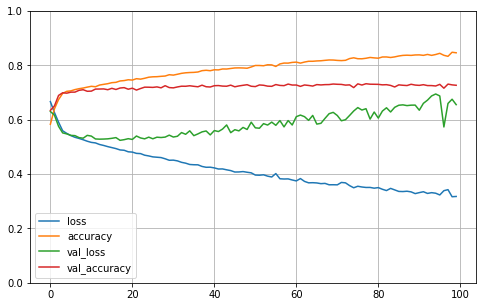

In [11]:
do_cross_validation(X,y)

In [12]:
from keras.models import load_model
X,y = prepare_inputs_len_x_alphabet(pc_test,nc_test,ALPHABET)
best_model=load_model(MODELPATH)
scores = best_model.evaluate(X, y, verbose=0)
print("The best model parameters were saved during cross-validation.")
print("Best was defined as maximum validation accuracy at end of any epoch.")
print("Now re-load the best model and test it on previously unseen data.")
print("Test on",len(pc_test),"PC seqs")
print("Test on",len(nc_test),"NC seqs")
print("%s: %.2f%%" % (best_model.metrics_names[1], scores[1]*100))


The best model parameters were saved during cross-validation.
Best was defined as maximum validation accuracy at end of any epoch.
Now re-load the best model and test it on previously unseen data.
Test on 1000 PC seqs
Test on 1000 NC seqs
accuracy: 98.85%


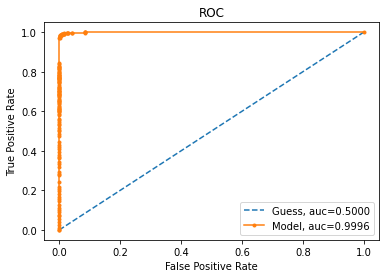

AUC: 99.96%


In [13]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
ns_probs = [0 for _ in range(len(y))]
bm_probs = best_model.predict(X)
ns_auc = roc_auc_score(y, ns_probs)
bm_auc = roc_auc_score(y, bm_probs)
ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
bm_fpr, bm_tpr, _ = roc_curve(y, bm_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Guess, auc=%.4f'%ns_auc)
plt.plot(bm_fpr, bm_tpr, marker='.', label='Model, auc=%.4f'%bm_auc)
plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
print("%s: %.2f%%" %('AUC',bm_auc*100.0))


In [14]:
t = time.time()
time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t))

'2021-06-21 18:14:05 UTC'